In [1]:
# change dir because notebook is in a child directory of the root directory (and does not find my modules)
import os 
try:
    os.chdir(r'/Users/joan/code/python/jokes-app')
except FileNotFoundError:
    os.chdir(r'/home/repos/joke-app')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import src.api.src.db.core as db
try:
    from src.api.src.db.secret import (
        HOST_OVH as HOST, 
        POSTGRES_USER, 
        POSTGRES_PASSWORD_OVH as POSTGRES_PASSWORD, 
        SCHEMA_NAME
    )
except ImportError:
    from src.api.src.db.secret import HOST, POSTGRES_USER, POSTGRES_PASSWORD, SCHEMA_NAME

### Get connection to Postgres DB

In [4]:
conn = db.connect(host=HOST, user=POSTGRES_USER, password=POSTGRES_PASSWORD, schema_name=SCHEMA_NAME)

### Get Number of subscribed users and unsubscribed users

In [5]:
df = db.execute_read(conn, "select * from users_mail")

In [6]:
n_subbed = df["deleted_at"].isna().sum()
n_unsubbed = len(df) - n_subbed

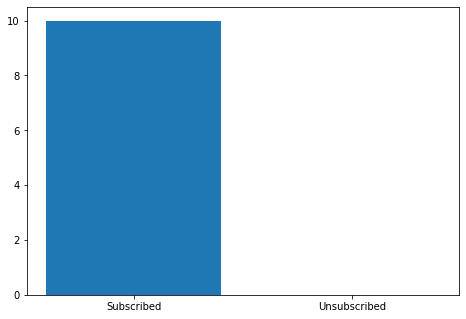

In [7]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
l_bars = ['Subscribed', 'Unsubscribed']
ax.bar(l_bars, [n_subbed, n_unsubbed])
plt.show()

### Top 10 Joke reviewers

In [8]:
df_mean_user = db.execute_read(conn, """
select 
	um.email, avg(r.rating), count(r)
from 
	ratings as r
left join users_mail as um
on (r.user_id = um.id_hash)
where "source" = 'mail' and um.email is not null
group by um.email
order by count(r.rating) desc
""")

In [9]:
df_mean_user.head(10)

,email,avg,count
0,watxaut@gmail.com,7.031250,16
1,jaime.conde@ficosa.com,2.000000,10
2,irene.chausse@mosaicfactor.com,6.111111,9
3,antoni.martinezlopez@ficosa.com,2.812500,8
4,18mariaff@gmail.com,6.000000,5
5,guillem.mcid@gmail.com,5.000000,1
6,Extern.javier.gris@seat.es,7.500000,1
7,Javier.heras@volkswagen-groupservices.com,2.500000,1


### AVG joke rating per user

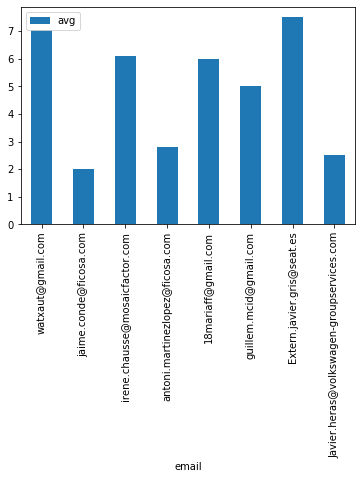

In [10]:
df_mean_user.head(10).plot.bar(x="email", y="avg")

### Rating Statistics

In [11]:
df_ratings = db.execute_read(conn, """select joke_id, rating, created_at from ratings where "source" = 'mail'""")

#### Get last 10 ratings

In [12]:
df_ratings.tail(10)

,joke_id,rating,created_at
42,140,7.5,2019-11-04 07:33:42.714198
43,140,5.0,2019-11-04 09:55:53.269481
44,41,0.0,2019-11-05 07:38:13.912179
45,41,7.5,2019-11-05 07:39:44.811829
46,41,7.5,2019-11-05 08:15:27.859408
47,41,7.5,2019-11-05 07:37:48.255108
48,1192,7.5,2019-11-06 07:30:57.750327
49,1192,5.0,2019-11-06 07:34:04.263492
50,1192,2.5,2019-11-06 07:35:22.559546
51,1192,5.0,2019-11-06 07:45:38.258561


### Get mean of ratings by joke and day

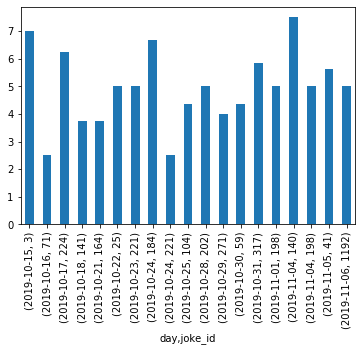

In [13]:
df_ratings["day"] = df_ratings["created_at"].dt.strftime('%Y-%m-%d')
df_ratings.groupby(["day", "joke_id"])["rating"].mean().plot.bar(x="day", y="rating")

### Get Std Deviation of ratings by joke and day

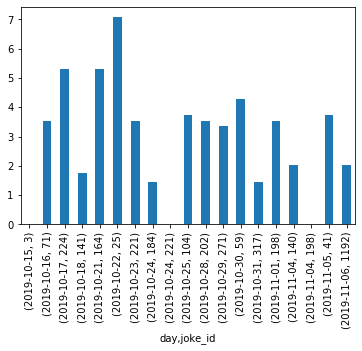

In [14]:
df_ratings.groupby(["day", "joke_id"])["rating"].std().plot.bar(x="day", y="rating")